In [2]:
'''Core updated as of March 7th  with Leonardo's fixes'''
import numpy as np
from numpy import random as npr
import pandas as pd
from matplotlib import pyplot as plt
import copy
import itertools
# import itertools as it'

In [3]:
# INITIAL DATA:_____________________________________________
cooperate = np.array( [ 1, 0 ] )
defect = np.array( [ 0, 1 ] )

# default Payoff matrix
default_R = 2
default_S = 0
default_T = 3
default_P = 1
Payoff = np.array( [ [ default_R , default_S ], [ default_T, default_P ] ] )

N_ROUNDS = 10

In [4]:
# NEW STRATEGIES:________________________________________________

# defining all strategies
# # template function
# parameter_list = [ k, ]
# def strategy( round_number = 0, match_history = [[]], player_index = 0 ) : 
#     # move either cooperate or defect
#     move
#     return move 

# nice guy function
def nice_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    return move 

# bad guy function
def bad_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = defect
    return move 

# percentage of defect for mainly nice ( and 1-k percentage of cooperate for mainly bad) Global Variable
k = 0.25

# mainly nice guy: randomly defect k% of the times and cooperate 100-k %, k<50
def mainly_nice( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < k ) : move = defect
    else :         move = cooperate
    return         move

# mainly bad guy: randomly defect k% of the times and cooperate 100-k %, k>50
def mainly_bad( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

# random guy: randomly defect or cooperate
def random_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < 0.5 ) : move = defect
    else :           move = cooperate
    return           move

# tit_for_tat function:  start by cooperating, then repeat what the opponent has done in the previous move
def tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = cooperate
    else :                     move = match_history[ round_number - 1 ][ 1 - player_index ]
    return                     move

# resentful guy function: cooperate until the opponent defects once, then always defect
def resentful_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    if ( round_number > 0 ) :
        for res in match_history : 
            # if any result matching a defect is found, the move is set to defect
            if np.array_equal( res[ 1 - player_index  ], defect ) : move = defect
            # if a defect is found, he would break    
            break
    return move

# trusting guy (increasing odds of cooperating according to match history):
# initially is like random guy (coop/defect at k=50%), then updates k
def trusting_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # starting trust
    k_t = 0.5
    # environmental trust
    if ( round_number > 0 ) :
        # number of cooperative behaviour met
        coop = 0. 
        # increase the value of cooperation by one each cooperation (element 0) seen from the other player (index 1-player_index)
        for res in match_history : coop += res[ 1 - player_index  ][ 0 ]
        # normalizing result over the match history
        k_t = coop / len( match_history )
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

# balancing guy (cooperates only for an even cooperation history)
def balancing_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    move = defect
    if ( round_number > 0 ) :
        # total cooperation seen
        coop = 0
        # increase the value of cooperation by one each cooperation (element 0) seen from each side during the match
        for res in match_history : coop += ( res[ 0 ][ 1 ] + res[ 1 ][ 1 ])
        if ( ( coop % 2 ) == 0 ) : move = cooperate
    return                         move

# Mid resentful: cooperates on the first move, and defects if the opponent has defected on any of the previous 3 moves, else cooperates
def mid_resentful( round_number = 0, match_history = [[]], player_index = 0):
    move = cooperate
    # selecting the oldest round to check, 3 before the current one if possible, the starting round otherwise
    start = max(0, round_number - 3)
    for round_i in range( start, round_number ):
        # checking if one of the previous move of the opponent (1-player_index) mach a defect
        if np.array_equal( match_history[round_i][1 - player_index], defect ):   
            move = defect
            # if a result is found, the cycle can break
            break
    return move

# reverse tit_for_tat function: start by defecting, then does the opposite of what the opponent has done in the previous move
def reverse_tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = defect
                               # in this way i obtain the opposite move: [1,1] - [1,0] = [0,1] and [1,1] - [0,1] = [1,0]
    else :                     move = [1,1] - match_history[ round_number - 1 ][ 1 - player_index ]  
    return                     move

# learning to scam guy: start by defecting, then cooperating two times; for the following turns chose the optimal condition:
# if the opponent never defected, he will defect to scam the opponent
# if the opponent cooperated while he cooperated more than he was scammed, he will cooperate, because he sees some kind of intelligence
# otherwise he'll defect to avoid beeing scammed
def scamming_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # default move is defect
    move =  defect
    # selecting first tree moves
    if ( round_number == 0 )   : 
        # print( f"round {round_number}: I defect" )
        move = defect
    elif ( round_number == 1 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    elif ( round_number == 2 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    else :
        # counting number of matching cooperation isses and defected from 0
        matching_coop = 0
        scammed = 0
        # deciding how much history to check
        first_r = npr.randint( 3, ( round_number + 1 ), dtype = int )
        # print( first_r )
        # searching over match history
        for i in range( round_number ) :
            # checking if the result cooperate, cooperate occurs
            if( np.array_equal( match_history[i][0], cooperate ) and np.array_equal( match_history[i][1], cooperate ) ) :
                matching_coop += 1
            # checking if the result cooperate, defect occurs in favour of the opposite side
            elif( np.array_equal( match_history[i][1 - player_index], defect ) and np.array_equal( match_history[i][player_index], cooperate ) ) :
                scammed += 1
        # checking if the opponent ever defected
        if( np.all( np.array_equiv( np.array( [ match_history[i][ 1 - player_index ] for i in range( ( round_number - first_r ), round_number ) ] ) , cooperate ) ) ) :
            # print( f"The rival is too good, I defect" )
            move = defect
        elif( matching_coop >= scammed ) : 
            # print( f"The rival is smart, I cooperate" )
            move = cooperate
    return move

# dictionary of all strategies
strategies = {
    'NiceGuy' : nice_guy,
    'BadGuy' : bad_guy,
    'MainlyNice' : mainly_nice,
    'MainlyBad' : mainly_bad,
    'TitForTat' : tit_for_tat,
    'RandomGuy' : random_guy,
    'ResentfulGuy' : resentful_guy,
    'TrustingGuy' : trusting_guy,
    'Thanos' : balancing_guy,
    'MidResentful': mid_resentful,
    'ReverseTft': reverse_tit_for_tat,
    'ScammingGuy' : scamming_guy,
}


In [5]:
# NEW MATCH DEFINING FUNCTIONS:________________________________________________

# function to play one round 1 vs 1 for two different* strategies players
def round( key_1, key_2, round_number, match_history, M = Payoff ) :
    # computing minimum and maximum reward for normalization
    s = np.dot( cooperate, M.dot(defect) )
    t = np.dot( defect, M.dot(cooperate) )
    # getting strategies from dictionary
    S_1 = strategies[ key_1 ]
    S_2 = strategies[ key_2 ]
    # computing next move for each player
    u_1 = S_1( round_number, match_history, 0 )
    u_2 = S_2( round_number, match_history, 1 )
    # computing rewards for each player
    r_1 = np.dot( u_1, M.dot(u_2))
    r_2 = np.dot( u_2, M.dot(u_1))
    # normalizing results
    r_1 = float( r_1 - s ) / float( t - s )
    r_2 = float( r_2 - s ) / float( t - s )
    # updating match history
    match_history.append( [ u_1, u_2 ] )
    # returning results
    return r_1, r_2

# function to play a match of N rounds 1 vs 1 for two different* strategies player
def match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
    # match history strarting empty
    history = [ ]
    # starting total rewards
    R_1 = 0
    R_2 = 0
    # list of partial sums
    Rewards = []
    for round_i in range( 0, N_rounds ) :
        r_1, r_2 = round( key_1, key_2, round_i, history, M )
        R_1 += r_1
        R_2 += r_2
        #Rewards.append( [ R_1, R_2 ] )
        # normalizing results to round played up this moment
        Rewards.append( [ float(R_1)/(round_i+1), float(R_2)/(round_i+1) ] )
    # returns the history list of partial sums of rounds rewards
    return Rewards

In [6]:
def tourney(participants={},N_rounds = 10, M = Payoff):
    # Retrieve only the names of the strategies repeated as many times as their frequency allows.
    player_list_from_dict = []
    for item in (list(participants.keys())):
        for i in range (participants[item]):
            player_list_from_dict.append(item)
    # Compute the combinations; List which will be used to have the scores of each match by the side of the two opponents
    list_with_scores = list(itertools.combinations(player_list_from_dict, 2))
    N_giornata = len(list_with_scores)
    # Loop over the combinations one by one
    for i in range (N_giornata):
        # Player1 and Player2 strategies
        player1 = list_with_scores[i][0]
        player2 = list_with_scores[i][1]
        # Initiliaze an empty list to store the results over the match
        AllRewards = []
        # Do the match between the two players and update the rewards; The ordered syntax for match is:
        # match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
        AllRewards =  match(player1, player2, N_rounds, M)
        # Retrieve the final scores for Player1 and Player2 as the last element in the list
        R1, R2 = AllRewards[-1][0], AllRewards[-1][1]
        list_with_scores[i] += (R1,R2)
    # Un-comment the following print to debug
    #for item in list_with_scores: print(item)
    
    # Good, now each combination has the corresponding score: we now need to assign it to the respective players and calculate the final score
    strat = list(participants.keys())
    freq = [participants[key] for key in strat]
    named =[]
    # Add identification to the layer trough the use of a numerical value from 1 up to their frequency BUT PRESERVE THE ORDER
    for key,f in zip (strat,freq):
        for j in range(1,f+1):
            if (f!=0):
                named.append(key + str(j))
    # Compute the permutations preserving the order
    with_names = list(itertools.combinations(named,2))
    # Copy the scores for each match over to the ones with identification
    # In list_with_scores[I][J] we have: I = ordered number of the combination, and J:
    # J=0 is 1st strategy; J=1 is 2nd strategy; J=2 is Player1 score; J=3 is Player2 score
    for i in range (N_giornata): with_names[i] += (list_with_scores[i][2],list_with_scores[i][3] )
    # Un-comment the following print to debug
    #for item in with_names: print(item)

    # Compute the score for each named player and add it to the list
    FinalScores = []
    for player in named:
        SumOver1 = np.sum([ with_names[i][2] for i in range (N_giornata) if (with_names[i][0] == player) ])
        SumOver2 = np.sum([ with_names[i][3] for i in range (N_giornata) if (with_names[i][1] == player) ])
        #FinalScores.append(SumOver1 + SumOver2)
        # Normalize the score by the number of opponents in the tourney
        FinalScores.append( (SumOver1 + SumOver2)/(np.sum(freq)-1) )
    Results = named
    
    for i in range (len(Results)):
        Results[i] = (Results[i],FinalScores[i])

    return ( Results )    

In [7]:
# Tourney test
test_part ={ 
    'NiceGuy' : 1,
    'BadGuy' : 1,
    'MainlyNice' : 1,
    'MainlyBad' : 1,
    'RandomGuy' : 1,
    'TitForTat' : 1,
    'ResentfulGuy' : 1,
    'TrustingGuy' : 1,
    'Thanos' : 1,
    'MidResentful' : 1,
    'ReverseTft': 1,
    'ScammingGuy': 1,
}

result = tourney(test_part,N_rounds = N_ROUNDS, M = Payoff)
#for item in result: print(item)
print("Here's the Ranking for the top 12 players at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking = sorted(result,reverse=True, key=lambda x: x[1])
for item in (Ranking[:12]): print(f"{item[0]:<15} {item[1]:.3f}")

Here's the Ranking for the top 12 players at the end of the tourney:
BadGuy1         0.594
ScammingGuy1    0.552
ResentfulGuy1   0.533
RandomGuy1      0.509
MidResentful1   0.506
TitForTat1      0.494
Thanos1         0.491
TrustingGuy1    0.482
MainlyBad1      0.470
MainlyNice1     0.467
ReverseTft1     0.388
NiceGuy1        0.352


In [45]:
# Retrieve the participants to the tourney as the players with non-zero frequency: needed to avoid divisions by zero with the mean
labels = [ x for (x,f) in test_part.items() if f!=0 ]
# Get the name of the player, that is the strategy with numerical identifier
players = [ result[i][0] for i in range (len(result)) ]
# Get their respective scores
rewards = [ result[i][1] for i in range (len(result)) ]

mean_rewards= []
index = 0

for item in players:
    # Make it a string to apply the count method: returns the number of times a substring is included in the main string
    f = str(players).count(item)
    # Compute the mean of their rewards: since players in result are listed in strategy order this is valid
    mean = (np.sum(rewards[index:index+f]))/f
    mean_rewards.append(mean)
    index += f
mean_result = list(zip(labels, mean_rewards))
mean_ranking = sorted(mean_result,reverse=True, key=lambda x: x[1])
for item in mean_ranking: print(f"{item[0]:<15} {item[1]:.3f}")

BadGuy          0.588
TrustingGuy     0.545
MidResentful    0.542
ResentfulGuy    0.530
ScammingGuy     0.509
MainlyBad       0.497
TitForTat       0.497
Thanos          0.491
RandomGuy       0.464
ReverseTft      0.418
MainlyNice      0.364
NiceGuy         0.333


In [59]:
def mean_tourney(participants={},N_rounds = 10, M = Payoff,repeats=10):
    # Retrieve the participants to the tourney as the players with non-zero frequency: needed to avoid divisions by zero with the mean
    labels = [ x for (x,f) in participants.items() if f!=0 ]
    mean_ranking = dict( [(l,0) for l in labels ] )
    
    for j in range(0,repeats):
        result = tourney(participants, N_rounds,M)
        
        # Get the name of the player, that is the strategy with numerical identifier
        players = [ result[i][0] for i in range (len(result)) ]
        # Get their respective scores
        rewards = [ result[i][1] for i in range (len(result)) ]
        # Array to store the result by strategy: order is the same as the dictionary
        mean_rewards= []
        index = 0
        for item in labels:
            # Make it a string to apply the count method: returns the number of times a substring is included in the main string
            f = str(players).count(item)
            # Compute the mean of their rewards: since players in result are listed in strategy order this is valid
            mean = (np.sum(rewards[index:index+f]))/f
            mean_rewards.append(mean)
            index += f
        for k, key in enumerate(mean_ranking.keys()): mean_ranking[key] += mean_rewards[k]/repeats
            
    mean_df = pd.DataFrame(mean_ranking.values(),index=mean_ranking.keys(),columns=["Mean Score"])
    return(mean_df)
t_df = mean_tourney(test_part,N_rounds = N_ROUNDS, M = Payoff,repeats=10)
t_df

,Mean Score
NiceGuy,0.39
BadGuy,0.64
MainlyNice,0.64
MainlyBad,0.40
RandomGuy,0.50
TitForTat,0.52
ResentfulGuy,0.55
TrustingGuy,0.39
Thanos,0.50
MidResentful,0.53


In [9]:
# Syntax [T,R,P,S]
def get_new_Payoff(par_list=[3,2,1,0]):
    if (len(par_list)!= 4):
        raise TypeError("Invalid parameter list for Payoff matrix")
    new_R = par_list[1]
    new_S = par_list[3]
    new_T = par_list[0]
    new_P = par_list[2]
    # Sanity checks
    if (np.min(par_list)!=new_S): raise ValueError("Parameters do not satisfy boundary conditions: S is not the smallest value")
    if (new_S == new_P): raise ValueError("Parameters do not satisfy boundary conditions: S is not strictly smaller than P")
    if (np.max(par_list)!=new_T): raise ValueError("Parameters do not satisfy boundary conditions: T is not the biggest value")
    if (new_R == new_T): raise ValueError("Parameters do not satisfy boundary conditions: T is not strictly greater than R")
    if (new_P >= new_R): raise ValueError("Parameters do not satisfy boundary conditions: R is not greater than P")
    if (2*new_R <= new_T + new_S ): raise ValueError("Parameters do not satisfy boundary conditions: 2R is not greater than T+S")
    return np.array([ [ new_R , new_S ], [ new_T, new_P ] ])

def test_parameters(max_T,max_R=0):
    if (max_R == 0): max_R = int(max_T -1)
    set_of_parameters = []
    for t in range (3,max_T+1):
        max_coop = np.minimum(t-1,max_R)
        for r in range (2,max_coop+1):
            value = np.maximum(0,2*r-t)
            # possible_P = np.arange(value,r,1)
            possible_S = np.arange(0,value,1)
            # Un-comment the following for debug
            #if (len(possible_S)!=0 and len(possible_P)!=0):
                #print(f"For T={t}, R={r}, we get the possible:")
                #print("P: ", possible_P)
                #print("S: ", possible_S)
            for s in possible_S :
                possible_P = np.arange(s+1,r,1)
                for p in possible_P : 
                    set_of_parameters.append(( t, r, p, s )) 
    # Create a structured array in order to sort the results prioritizing T>R>P>S
    dtype = [('T', int), ('R', int), ('P', int), ('S', int)]
    matrix = np.array(set_of_parameters, dtype=dtype )
    matrix.sort(axis=0, order=['T','R','P','S'])
    set_of_parameters = []
    for item in matrix:
        set_of_parameters.append(list(item))
        
    return (np.array(set_of_parameters))

In [10]:
# Sanity check
# Original fixed 
p_t = test_parameters(10)
for item in p_t:
    assign_test = get_new_Payoff(item)
    #print(f"{item} is ok")

In [11]:
# Retrieve the matrix values with the highest tested parameter
biggest_T = p_t[p_t[:,0]==p_t[-1,0]]
#print(biggest_T)

In [12]:
# Get the coefficients with the biggest disparity between T (succesfully defecting) and R (succesfully cooperating)
Most_Evil = get_new_Payoff(biggest_T[0])
# Get the coefficients with the lest disparity between T (succesfully defecting) and R (succesfully cooperating) but still high coeff values
Least_Evil = get_new_Payoff(biggest_T[-1])

result_Most_Evil = tourney(test_part,N_rounds = 10, M = Most_Evil)
#for item in result: print(item)
print("With Payoff Matrix: " + "\n", Most_Evil)
print("Here's the Ranking at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking_Most_Evil = sorted(result_Most_Evil,reverse=True, key=lambda x: x[1])
for item in Ranking_Most_Evil: print(f"{item[0]:<15} {item[1]:.3f}")

result_Least_Evil = tourney(test_part,N_rounds = 10, M = Least_Evil)
#for item in result: print(item)
print("\nWith Payoff Matrix: " + "\n" , Least_Evil)
print("Here's the Ranking at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking_Least_Evil = sorted(result_Least_Evil,reverse=True, key=lambda x: x[1])
for item in Ranking_Least_Evil: print(f"{item[0]:<15} {item[1]:.3f}")

With Payoff Matrix: 
 [[ 6  0]
 [10  1]]
Here's the Ranking at the end of the tourney:
BadGuy1         0.444
ScammingGuy1    0.428
MidResentful1   0.424
ReverseTft1     0.416
ResentfulGuy1   0.415
MainlyBad1      0.406
TitForTat1      0.406
RandomGuy1      0.401
TrustingGuy1    0.382
MainlyNice1     0.359
Thanos1         0.354
NiceGuy1        0.327

With Payoff Matrix: 
 [[ 9  7]
 [10  8]]
Here's the Ranking at the end of the tourney:
BadGuy1         0.594
MidResentful1   0.530
MainlyBad1      0.524
TrustingGuy1    0.524
RandomGuy1      0.509
ResentfulGuy1   0.503
ScammingGuy1    0.500
TitForTat1      0.488
Thanos1         0.470
MainlyNice1     0.433
ReverseTft1     0.430
NiceGuy1        0.333


In [13]:
# Are these significative? Let's check by normalizing for both the total number of match played and the highest value of Payoff matrix


In [14]:
# What about our original results?
print("Normalized scores with Payoff Matrix: " + "\n", Payoff)
for item in result: print(f"{item[0]:<15} {item[1]:.3f}")

Normalized scores with Payoff Matrix: 
 [[2 0]
 [3 1]]
NiceGuy1        0.352
BadGuy1         0.594
MainlyNice1     0.467
MainlyBad1      0.470
RandomGuy1      0.509
TitForTat1      0.494
ResentfulGuy1   0.533
TrustingGuy1    0.482
Thanos1         0.491
MidResentful1   0.506
ReverseTft1     0.388
ScammingGuy1    0.552


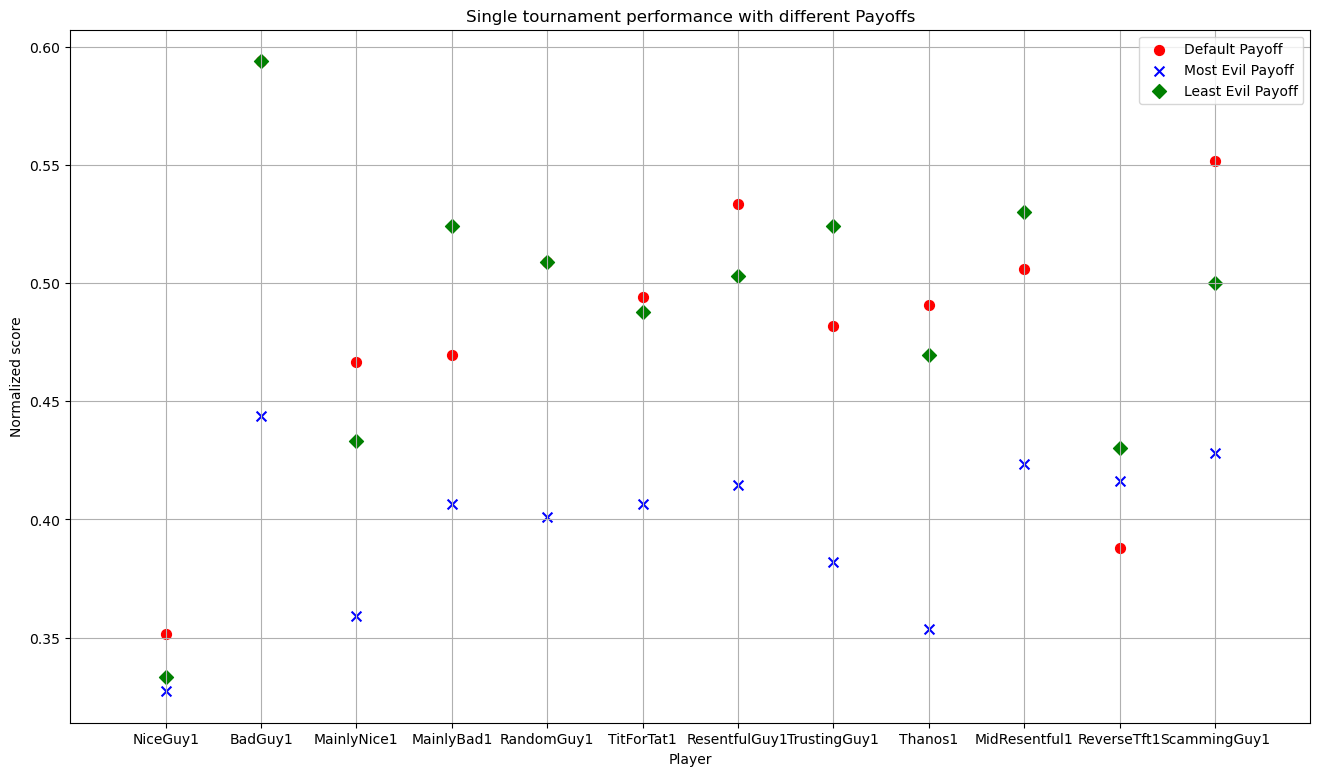

In [15]:
# Scatter plot to visualize results
names = [result[i][0] for i in range (len(result))]
x_vals = np.arange(1,len(names)+1,1)
y_res = [result[i][1] for i in range (len(result))]
y_most_evil = [result_Most_Evil[i][1] for i in range (len(result_Most_Evil))]
y_least_evil = [result_Least_Evil[i][1] for i in range (len(result_Least_Evil))]
#cmap = ["#e61212","#4f3307", "#cc8c14","#fcf112","#91f527","#7fffd4","#074f0d","#0df7ff","#0d208c","#6440a1","#f22ce8","#7fffd4"]

fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(x_vals, y_res, label = "Default Payoff", color = "red", marker  = "o", s=50)
ax.scatter(x_vals, y_most_evil, label = "Most Evil Payoff", color = "blue", marker = "x",s =50)
ax.scatter(x_vals, y_least_evil, label = "Least Evil Payoff", color = "green", marker = "D", s=50)
ax.set_title("Single tournament performance with different Payoffs")
ax.set_xlabel("Player")
ax.set_xlim(0,len(names)+1)
ax.set_xticks(x_vals)
ax.set_ylabel("Normalized score")

ax.set_xticklabels(names)
ax.grid()

ax.legend()
plt.show()


In [16]:
MAX_VALUE = 10
coeffs = test_parameters(MAX_VALUE)
print(len(coeffs))
# Retrieve the participants to the tourney as the players with non-zero frequency: needed to avoid divisions by zero with the mean
labels = [ x for (x,f) in test_part.items() if f!=0 ]

# In order to create adataframe to store matrix coefficients, 1st classified's score, 2nd and 3rd classified score differences we use a numpy
# array to first retrieve the data and then build the dataframe from there: we could use concat, but that basically generates a new 
# dataframe at each iteration, which is not ideal

# Use the "object" type for strings instead of dtype="U#" where # is the maximum chars that our strings will contain because, while slower,
# it will greatly simplify data type recognition in the pandas dataframe
winners_strategy = np.empty(shape=(len(coeffs),3),dtype="object")
winners_scores = np.zeros(shape=(len(coeffs),3),dtype=float)
# index to go through the above containers
i = 0

for c in coeffs:
    payoff_matrix = get_new_Payoff(c)
    result = tourney(test_part,N_rounds = N_ROUNDS, M = payoff_matrix)
    # Get the name of the player, that is the strategy with numerical identifier
    players = [ result[i][0] for i in range (len(result)) ]
    # Get their respective scores
    rewards = [ result[i][1] for i in range (len(result)) ]
    
    mean_rewards= []
    index = 0
    
    for item in players:
        # Make it a string to apply the count method: returns the number of times a substring is included in the main string
        f = str(players).count(item)
        # Compute the mean of their rewards: since players in result are listed in strategy order this is valid
        mean = (np.sum(rewards[index:index+f]))/f
        mean_rewards.append(mean)
        index += f
    mean_result = list(zip(labels, mean_rewards))
    mean_ranking = sorted(mean_result,reverse=True, key=lambda x: x[1])
    winners_strategy[i] = [ mean_ranking[0][0], mean_ranking[1][0], mean_ranking[2][0] ]
    winners_scores[i] = [ mean_ranking[0][1], mean_ranking[0][1] - mean_ranking[1][1], mean_ranking[0][1] - mean_ranking[2][1] ]
    i +=1
    
result_df = pd.DataFrame(np.hstack((coeffs,winners_strategy,winners_scores)),columns=("T","R","P","S","1st Strategy","2nd Strategy",
                                                                                      "3rd Strategy", "1st Score", "From 2nd","From 3rd") )
# Fix the number of digits showed
pd.options.display.float_format = '{:.4f}'.format
result_df

250


,T,R,P,S,1st Strategy,2nd Strategy,3rd Strategy,1st Score,From 2nd,From 3rd
0,3,2,1,0,BadGuy,TrustingGuy,MidResentful,0.6121,0.0667,0.0970
1,4,3,1,0,BadGuy,ResentfulGuy,ScammingGuy,0.5295,0.0114,0.0159
2,4,3,2,0,BadGuy,MidResentful,MainlyBad,0.7045,0.0682,0.1023
3,4,3,2,1,BadGuy,ResentfulGuy,MidResentful,0.6000,0.0788,0.0818
4,5,3,1,0,TrustingGuy,ScammingGuy,BadGuy,0.4945,0.0091,0.0109
...,...,...,...,...,...,...,...,...,...,...
245,10,9,8,3,BadGuy,MidResentful,ResentfulGuy,0.8156,0.0701,0.0935
246,10,9,8,4,BadGuy,MainlyBad,MidResentful,0.7909,0.0742,0.0803
247,10,9,8,5,BadGuy,ResentfulGuy,MainlyBad,0.7527,0.0655,0.0764
248,10,9,8,6,BadGuy,MidResentful,MainlyBad,0.7000,0.0727,0.0818


In [17]:
# On my hardware, ~12ms per tourney with N_ROUNDS=10, sow with test_parameters(30)-->23625 combinations---> ~5mins
result_df.to_pickle(f"MaxT-{MAX_VALUE}.pkl")
#pd.read_pickle

In [31]:
prova=get_new_Payoff([10,9,8,7])
verifica = tourney(test_part,N_rounds = N_ROUNDS, M = prova)
verifica.sort(reverse=True, key=lambda x: x[1])
for item in verifica: print(f"{item[0]:<15} {item[1]:.3f}")

classifica_first = {(key+"1"):0 for key in test_part.keys()}
classifica_second = {(key+"1"):0 for key in test_part.keys()}
classifica_third = {(key+"1"):0 for key in test_part.keys()}

n_media = 40

for i in range(n_media):
    verifica = tourney(test_part,N_rounds = N_ROUNDS, M = prova)
    verifica.sort(reverse=True, key=lambda x: x[1])
    #print(f"1st: {verifica[0][0]:<15} score: {verifica[0][1]:.6f}")
    #print(f"2nd: {verifica[1][0]:<15} score: {verifica[1][1]:.6f}")
    #print(f"3rd: {verifica[2][0]:<15} score: {verifica[2][1]:.6f}")
    classifica_first.update( {str(verifica[0][0]): classifica_first[str(verifica[0][0])] + 1} )
    classifica_second.update( {str(verifica[1][0]): classifica_second[str(verifica[1][0])] + 1} )
    classifica_third.update( {str(verifica[2][0]): classifica_third[str(verifica[2][0])] + 1} )

for key in classifica_first.keys():
    classifica_first[key] = classifica_first[key]/n_media*100
    classifica_second[key] = classifica_second[key]/n_media*100
    classifica_third[key]= classifica_third[key]/n_media*100
    
out_iter =pd.concat([pd.DataFrame(classifica_first.values(),index=classifica_first.keys(),columns=["First %"])
                     ,pd.DataFrame(classifica_second.values(),index=classifica_second.keys(),columns=["Second %"])
                     ,pd.DataFrame(classifica_third.values(),index=classifica_third.keys(),columns=["Third %"])],axis=1)
pd.options.display.float_format = '{:.2f}'.format
out_iter

BadGuy1         0.582
MidResentful1   0.539
ResentfulGuy1   0.536
TitForTat1      0.521
TrustingGuy1    0.518
ScammingGuy1    0.515
Thanos1         0.497
MainlyBad1      0.470
ReverseTft1     0.461
MainlyNice1     0.427
RandomGuy1      0.385
NiceGuy1        0.358


,First %,Second %,Third %
NiceGuy1,0.00,0.00,0.00
BadGuy1,92.50,7.50,0.00
MainlyNice1,0.00,0.00,0.00
MainlyBad1,0.00,37.50,5.00
RandomGuy1,0.00,2.50,0.00
TitForTat1,0.00,0.00,2.50
ResentfulGuy1,0.00,17.50,35.00
TrustingGuy1,7.50,15.00,12.50
Thanos1,0.00,0.00,0.00
MidResentful1,0.00,10.00,35.00


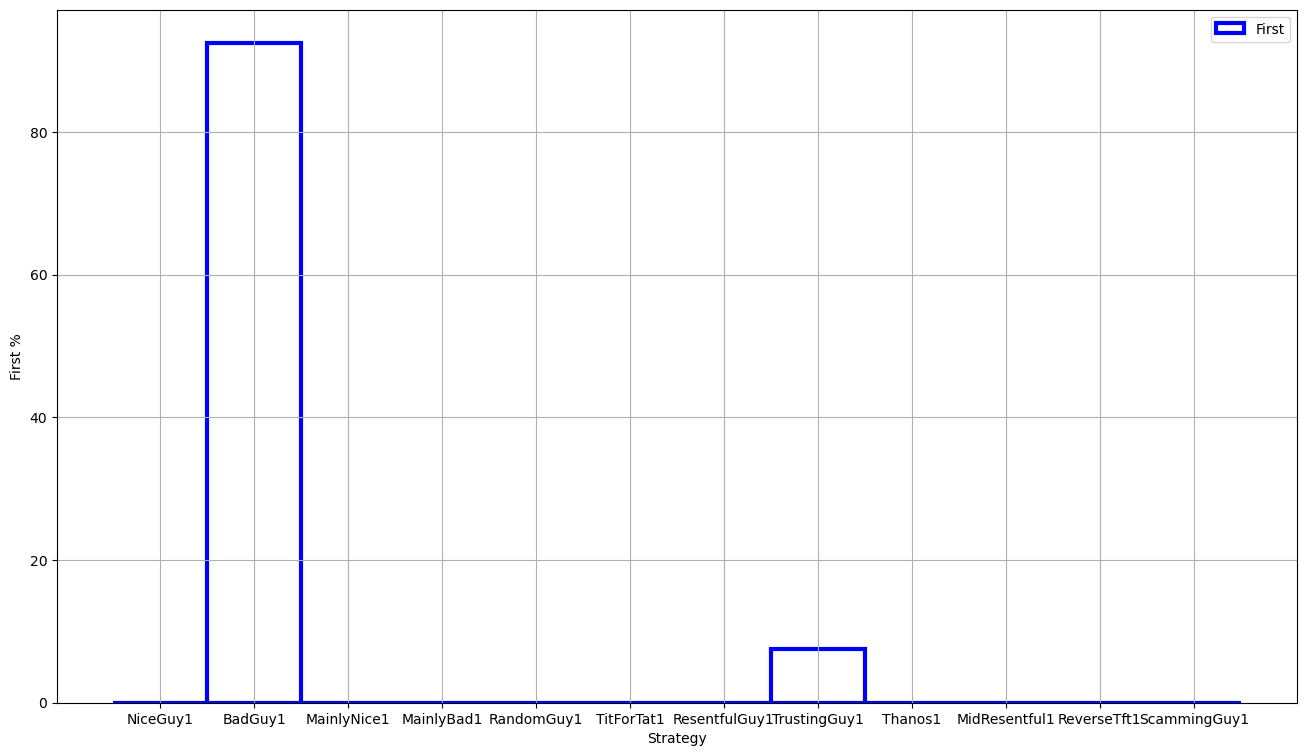

In [32]:
fig, ax = plt.subplots(figsize=(16,9))
centers = np.arange(0,len(classifica_first))
labels = list(classifica_first.keys())
freq = list(classifica_first.values())
#ax.scatter(centers,freq)
ax.set_xticks(ticks=centers, labels=labels)
ax.grid()
ax.set_xlabel("Strategy")
ax.set_ylabel("First %")
plt.bar(classifica_first.keys(),classifica_first.values(),1,edgecolor="blue",label="First",fill=False,ls="-",lw=3)
#plt.bar(classifica_second.keys(),classifica_second.values(),1,edgecolor="orange",label="Second",fill=False,ls="-",lw=2)
ax.legend()
plt.show()

In [20]:
w30 = pd.read_pickle("MaxT-30.pkl")
w30

,T,R,P,S,1st Strategy,2nd Strategy,3rd Strategy,1st Score,From 2nd,From 3rd
0,3,2,1,0,BadGuy,TrustingGuy,MidResentful,0.59,0.04,0.05
1,4,3,1,0,TrustingGuy,BadGuy,RandomGuy,0.55,0.02,0.02
2,4,3,2,0,BadGuy,MidResentful,ResentfulGuy,0.70,0.09,0.10
3,4,3,2,1,MainlyBad,BadGuy,ResentfulGuy,0.60,0.01,0.08
4,5,3,1,0,BadGuy,TrustingGuy,MidResentful,0.53,0.06,0.07
...,...,...,...,...,...,...,...,...,...,...
245,10,9,8,3,BadGuy,MainlyBad,MidResentful,0.83,0.07,0.09
246,10,9,8,4,BadGuy,MainlyBad,MidResentful,0.80,0.09,0.09
247,10,9,8,5,BadGuy,MidResentful,ResentfulGuy,0.77,0.09,0.10
248,10,9,8,6,BadGuy,TrustingGuy,MidResentful,0.68,0.04,0.06


In [34]:
#1st places for strategies in %: get the frequency of first places with size and normalize by the total
ones = w30.groupby(["1st Strategy"]).size()/(w30.groupby(["1st Strategy"]).size().sum())*100
twos = w30.groupby(["2nd Strategy"]).size()/(w30.groupby(["2nd Strategy"]).size().sum())*100
threes = w30.groupby(["3rd Strategy"]).size()/(w30.groupby(["3rd Strategy"]).size().sum())*100
print(f"{"Strategy":<15} {"1st %":<6} {"2nd %":<6} {"3rd %":<6}")
for key in ones.keys():
    print(f"{key:<15} {ones[key]:.2f}  {twos[key]:.2f}  {threes[key]:.2f}")

Strategy        1st %  2nd %  3rd % 
BadGuy          71.20  10.00  3.20
MainlyBad       4.40  18.00  10.80
MainlyNice      0.40  0.80  1.60
MidResentful    4.80  26.00  35.60
RandomGuy       0.80  1.60  4.80
ResentfulGuy    8.00  20.40  19.60
ScammingGuy     0.40  2.80  2.00
TitForTat       3.60  5.60  6.40
TrustingGuy     6.40  14.80  15.20


In [35]:
bad_wins = (w30[w30["1st Strategy"]=="BadGuy"])[["T","R","P","S"]]
bad_wins
Tft_wins = (w30[w30["1st Strategy"]=="TitForTat"])[["T","R","P","S"]]
Tft_wins

,T,R,P,S
75,8,7,1,0
114,9,7,2,1
136,9,8,3,1
139,9,8,4,1
187,10,8,1,0
216,10,9,2,1
219,10,9,3,2
228,10,9,5,4
234,10,9,6,5


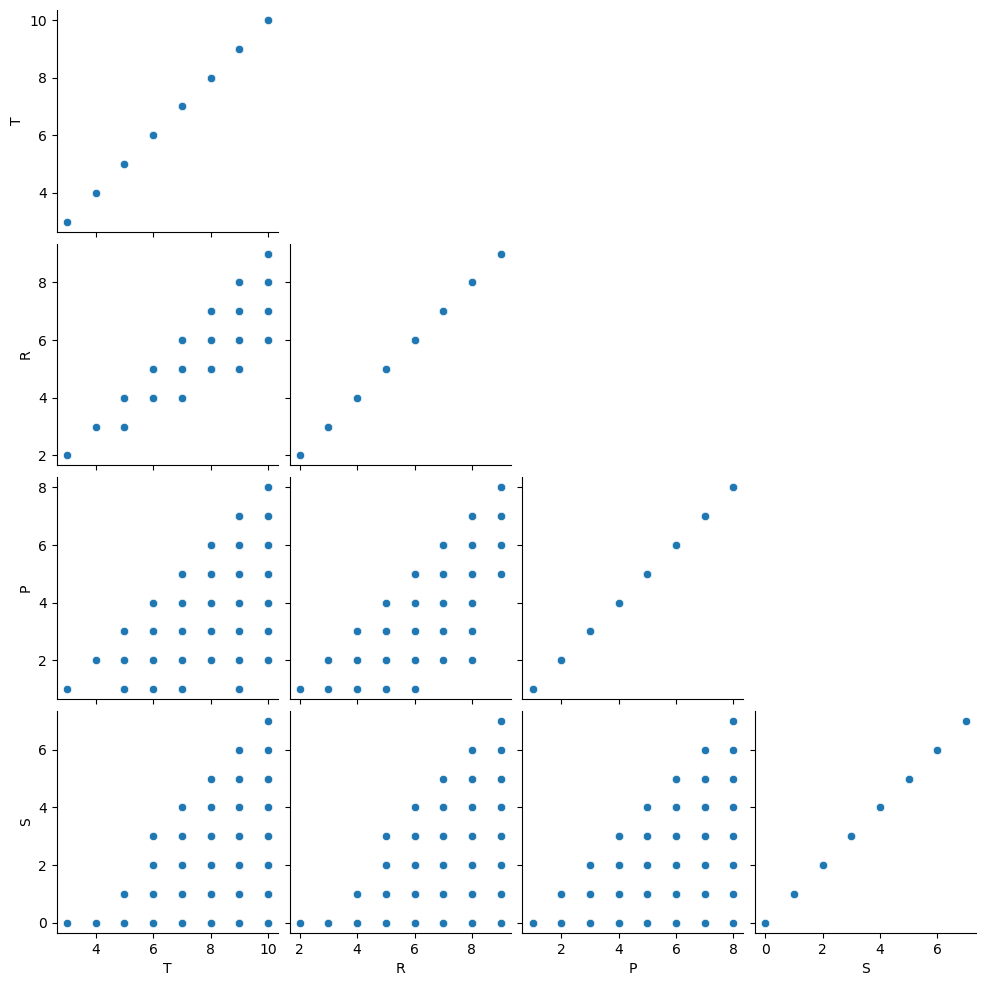

In [36]:
from seaborn import pairplot as pp
pp(bad_wins,diag_kind=None,corner=True)